In [1]:
#!/usr/bin/env python
# coding: utf-8

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

Trainset: (1500, 2), Testset: (1500,)


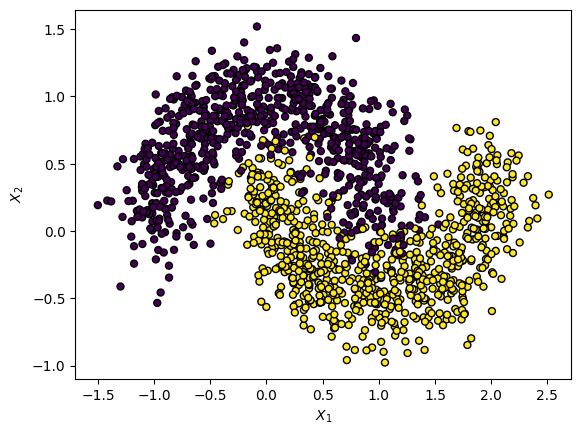

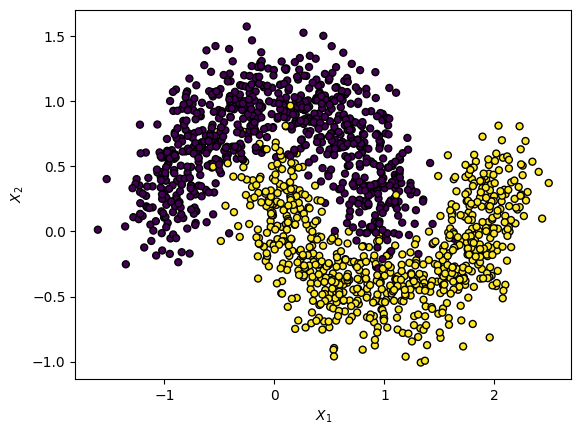

'\nplt.scatter(X_train[:, 1], X_train[:, 2], marker=\'.\', c=y_train, s=100,\n            edgecolor="k", linewidth=1)\nplt.xlabel("$X_1$")\nplt.ylabel("$X_2$")\nplt.show()\n\nplt.scatter(X_train[:, 0], X_train[:, 2], marker=\'.\', c=y_train, s=100,\n            edgecolor="k", linewidth=1)\nplt.xlabel("$X_1$")\nplt.ylabel("$X_2$")\nplt.show()\n'

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=3000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

print("Trainset: {}, Testset: {}".format(X_train.shape, y_train.shape))

plt.scatter(X_train[:, 0], X_train[:, 1], marker='.', c=y_train, s=100,
            edgecolor="k", linewidth=1)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', c=y_test, s=100,
            edgecolor="k", linewidth=1)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

'''
plt.scatter(X_train[:, 1], X_train[:, 2], marker='.', c=y_train, s=100,
            edgecolor="k", linewidth=1)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

plt.scatter(X_train[:, 0], X_train[:, 2], marker='.', c=y_train, s=100,
            edgecolor="k", linewidth=1)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()
'''

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

def get_models(r_state=42, n_est=50, lr=0.1):
    models = dict()
    models['log'] =  LogisticRegression(solver="lbfgs", random_state=42)
    models['sgd']= SGDClassifier(loss="hinge", learning_rate="constant",
                                 eta0=0.001, max_iter=10000, tol=1e-3,
                                 random_state=r_state)
    models['dt'] = DecisionTreeClassifier(random_state=r_state)
    models['rf'] = RandomForestClassifier(
                                          random_state=r_state)
    models['lsvm'] = SVC(kernel="linear", random_state=r_state)
    models['polsvm'] = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])
    models['vote'] = VotingClassifier(
        estimators=[('log', models['log']),
                    ('sgd', models['sgd']),
                    ('rf', models['rf']),
                    ('polsvm', models['polsvm'])],
        voting='hard')
    models['bag'] = BaggingClassifier(
        DecisionTreeClassifier(random_state=r_state), n_estimators=n_est,
        bootstrap=True, random_state=r_state)
    models['adab'] = AdaBoostClassifier(
        DecisionTreeClassifier(random_state=r_state), n_estimators=n_est,
        algorithm="SAMME.R", learning_rate=lr, random_state=r_state)
    models['grab'] = GradientBoostingClassifier(
        random_state=r_state)

    return models

In [4]:
from sklearn.metrics import accuracy_score
import time

def evaluate_model(model, X_train, X_test, y_train, y_test):
    start = time.time()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    elaptime = time.time() - start
    acc = accuracy_score(y_test, y_pred)
    return acc, elaptime

models = get_models()

results, names, times = list(), list(), list()
for name, model in models.items():
    acc, elaptime = evaluate_model(model, X_train, X_test,
                                   y_train, y_test)
    results.append(acc)
    times.append(elaptime)
    names.append(name)
    print('%s\t %.4f (time: %.3f)' % (name, acc, elaptime))

log	 0.8620 (time: 0.019)
sgd	 0.8607 (time: 0.004)
dt	 0.9620 (time: 0.004)
rf	 0.9700 (time: 0.324)
lsvm	 0.8593 (time: 0.036)
polsvm	 0.9687 (time: 0.027)


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


vote	 0.9193 (time: 0.304)
bag	 0.9660 (time: 0.190)
adab	 0.9627 (time: 0.005)
grab	 0.9673 (time: 0.192)


In [5]:
from sklearn.ensemble import StackingClassifier

def get_stacking(models, nfold=5):
    layer0 = list()
    layer0.append(('sgd', models['sgd']))
    layer0.append(('rf', models['rf']))
    layer0.append(('polsvm', models['polsvm']))
    layer0.append(('adab', models['adab']))
    layer0.append(('grab', models['grab']))
    layer1 = LogisticRegression()

    model = StackingClassifier(estimators=layer0,
                              final_estimator=layer1,
                              cv=nfold)
    return model


modelstack = dict()
modelstack['stack'] = get_stacking(models)

results, names, times = list(), list(), list()
for name, model in modelstack.items():
    acc, elaptime = evaluate_model(model, X_train, X_test,
                                   y_train, y_test)
    results.append(acc)
    times.append(elaptime)
    names.append(name)
    print('%s\t %.4f (time: %.3f)' % (name, acc, elaptime))

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

stack	 0.9667 (time: 2.629)


In [16]:
########################
##### YOUR METHOD ######
########################
# MUST: You should capture the below function in the report!
def get_stacking2(models, nfold=5):
    layer0 = list()
    ### append your chosen models as many as you want
    layer0.append(('polsvm', models['polsvm']))
    layer0.append(('bag', models['bag']))
    layer0.append(('grab', models['grab']))
    layer0.append(('rf', models['rf']))

    ### You can change layer1 if you are interested in though it is not recommended cuz it's hard work
    layer1 = LogisticRegression()

    model = StackingClassifier(estimators=layer0,
                              final_estimator=layer1,
                              cv=nfold)
    return model

In [17]:
modelstack = dict()
modelstack['your_stack'] = get_stacking2(models)

your_results, your_names, your_times = list(), list(), list()
for name, model in modelstack.items():
    acc, elaptime = evaluate_model(model, X_train, X_test,
                                   y_train, y_test)
    your_results.append(acc)
    your_times.append(elaptime)
    your_names.append(name)

print('%s\t %.4f (time: %.3f)' % (str(your_names[0]), float(your_results[0]), float(your_times[0])))

## checking/printing whether yours is better or not
diff = float(your_results[0]) - float(results[0])
dtime = float(times[0]) - float(your_times[0])
if diff > 0:
  print("Success:\n")
  print('%s is better than anchor at acc %.4f (saving time: %.3f s)'
        % (str(your_names), diff,dtime ))
else:
  print("Failed")
# MUST: You should capture the below running result in the report!

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

your_stack	 0.9713 (time: 3.997)
Success:

['your_stack'] is better than anchor at acc 0.0047 (saving time: -1.368 s)
